# 주제: CNN을 이용한 Image Classification 구현하고 성능 개선하기

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 import 가능합니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.

## 데이터 소개
    - 이번 주제는 Intel image classification dataset을 사용합니다.
    - Intel image classification dataset은 buildings, forest, mountains, glacier, sea, street 6개의 class로 구성되어 있습니다.
    - 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
    - 모든 데이터는 각 class 이름에 해당되는 directory 아래에 있습니다.    

    1. seg_train
      - training용 data
      
    2. seg_test
      - test/validation용 data
      - label 있음
      - 이번 실습에서는 validation data로 사용

    3. set_pred
      - test용 data
      - label 없음
      - 이번 실습에서는 사용하지 않음

- 원본 데이터 출처: https://www.kaggle.com/puneet6060/intel-image-classification

## 문제 소개
    - 이번 실습에서는 image classification model을 만들어서 학습하고, 성능을 향상하기 위한 방법들을 찾아서 학습해보도록 하겠습니다.

## 최종 목표    
    - pre-trained CNN 활용 방법 이해
    - CNN의 성능을 올리기 위한 다양한 방법 습득

- 출제자: 이진원 강사

## Step 1. 데이터 다운로드 및 전처리

In [1]:
## library를 import 합니다
## 추가로 필요한 library가 있으면 추가로 import 해도 좋습니다
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
## Hyper-Parameter 설정
# image resolution
RES = 224
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 50
# learning rate
LR = 0.0001

### 문제 1. 데이터 불러오기

    - data는 아래 url(google drive)에 저장되어 있습니다.(tar 파일)
    - gdown library를 이용하여 data를 다운받고, 현재 directory에 tar파일 압축을 풀어줍니다.
    

In [3]:
data_url = 'https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ'

In [4]:
## data download 받기(gdown.download 사용)
gdown.download(data_url, 'intel_image_classification.tar', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ
To: /content/intel_image_classification.tar
388MB [00:03, 110MB/s]


'intel_image_classification.tar'

In [5]:
!tar -xf ./intel_image_classification.tar

    - 아래와 같이 train dataset은 train_dir, validation dataset은 val_dir로 경로를 설정합니다

In [6]:
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [7]:
!ls $train_dir

buildings  forest  glacier  mountain  sea  street


### 문제 2. dataset 만들기
    - keras.preprocessing.image_dataset_from_directory를 이용하여 training용 dataset(이름: train_ds), validation용 dataset(이름: val_ds)를 만듭니다.
    - 위 hyperparameter를 참조하여 image_size와 batch_size를 설정합니다.
    - training data는 shuffle=True로 설정합니다.

In [8]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES, RES),
    batch_size=N_BATCH
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


### 문제 3. training data, validation data 갯수 확인
    - 위 dataset 생성시에 나오는 log에서 training data와 validation data의 갯수를 확인하여, 각각 N_TRAIN, N_VAL 변수에 저장합니다.

In [9]:
N_TRAIN = 14034
N_VAL = 3000

### 문제 4. class list 만들기
    - class 이름을 저장하고 있는 list를 생성합니다

In [10]:
# classes = ['buildings', 'forest', 'mountains', 'glacier', 'sea', 'street']
classes = train_ds.class_names
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


    - data 공급 속도를 빠르게 하기 위하여 dataset에 prefetch를 적용합니다

In [11]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

### 문제 5. dataset 확인하기
    - train_ds에서 batch를 5개 읽어와서 각 batch의 첫번째 image를 화면에 출력합니다.
    - 위 class list에서 image에 대한 label을 찾아서 title로 넣습니다.

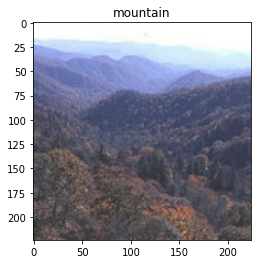

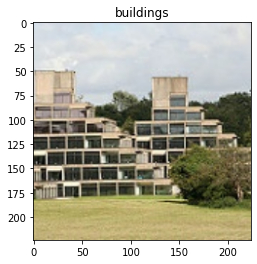

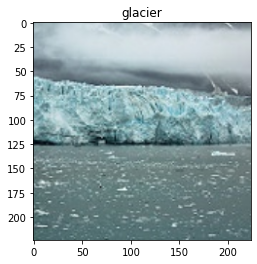

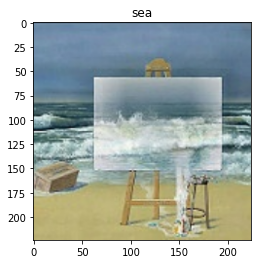

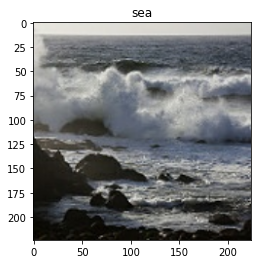

In [12]:
for images, labels in train_ds.take(5):
  plt.imshow(images[0].numpy().astype('uint8'))
  plt.title(classes[labels[0].numpy()])
  plt.show()  

## Step 2. Pretrained MobileNetV3로 Training 하기
이번 Step에서는 MobileNetV3를 이용하여 image classification을 학습해보겠습니다.

    - pretrained MobileNetV3는 tensorflow.keras.applications에서 기본으로 제공합니다.
    - 아래와 같이 pretrained MobileNetV3 model을 다운받습니다.
  

In [13]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

6701056/6698480 [==============================] - 0s 0us/step


In [14]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

### 문제 6. Intel image classification을 위한 MobileNetV3 model 만들기    
    - functional API를 활용하여 6개의 class를 classification하는 model을 만들어봅시다.
    - fully connected layer는 1개만 추가하고, batchnorm을 사용합니다.
    - MobileNetV3에 data가 들어가기 전에 preprocess_input을 적용하여 input data가 preprocessing될 수 있도록 합니다.

In [15]:
def create_model():
  inputs = keras.Input(shape=(RES, RES, 3))
  x = preprocess_input(inputs)
  x = mobilenetv3(x)
  x = GlobalAveragePooling2D()(x)
  x = Dense(N_CLASS)(x)
  x = BatchNormalization()(x)
  outpus = Softmax()(x)
  model = keras.Model(inputs=inputs, outputs=outpus)
  return model

In [16]:
model = create_model()

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
softmax (Softmax)            (None, 6)                 0         
Total params: 1,536,142
Trainable params: 1,524,018
Non-trainable params: 12,124
______________________________________________

  ### 문제 7. 학습하기
    - SGD를 사용하여 model을 학습합니다.(총 epoch수는 N_EPOCH으로 설정)
    - learning rate은 위에서 정한 hyperparameter(LR)을 사용합니다.
    - loss는 cross entropy를 사용합니다.

In [18]:
model.compile(keras.optimizers.SGD(learning_rate=LR), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50
220/220 [==============================] - 47s 123ms/step - loss: 2.1637 - accuracy: 0.1709 - val_loss: 1.8114 - val_accuracy: 0.2533
Epoch 2/50
220/220 [==============================] - 26s 117ms/step - loss: 1.8128 - accuracy: 0.2788 - val_loss: 1.5859 - val_accuracy: 0.3743
Epoch 3/50
220/220 [==============================] - 26s 117ms/step - loss: 1.5565 - accuracy: 0.3839 - val_loss: 1.4023 - val_accuracy: 0.4663
Epoch 4/50
220/220 [==============================] - 26s 117ms/step - loss: 1.3909 - accuracy: 0.4689 - val_loss: 1.2756 - val_accuracy: 0.5347
Epoch 5/50
220/220 [==============================] - 26s 117ms/step - loss: 1.2757 - accuracy: 0.5304 - val_loss: 1.1818 - val_accuracy: 0.5863
Epoch 6/50
220/220 [==============================] - 26s 117ms/step - loss: 1.1965 - accuracy: 0.5780 - val_loss: 1.1160 - val_accuracy: 0.6210
Epoch 7/50
220/220 [==============================] - 26s 117ms/step - loss: 1.1316 - accuracy: 0.6100 - val_loss: 1.0667 - val_ac

### 문제 8. Optimizer 변경하기
    - 같은 model에서 optimizer만 Adam으로 변경하여 학습해봅시다.

In [19]:
model = create_model()

In [20]:
model.compile(keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50
220/220 [==============================] - 32s 122ms/step - loss: 0.6573 - accuracy: 0.8593 - val_loss: 0.4372 - val_accuracy: 0.9103
Epoch 2/50
220/220 [==============================] - 26s 118ms/step - loss: 0.4849 - accuracy: 0.9258 - val_loss: 0.4921 - val_accuracy: 0.9250
Epoch 3/50
220/220 [==============================] - 26s 118ms/step - loss: 0.4336 - accuracy: 0.9387 - val_loss: 0.5118 - val_accuracy: 0.9277
Epoch 4/50
220/220 [==============================] - 26s 118ms/step - loss: 0.3996 - accuracy: 0.9478 - val_loss: 0.5208 - val_accuracy: 0.9300
Epoch 5/50
220/220 [==============================] - 26s 118ms/step - loss: 0.3678 - accuracy: 0.9579 - val_loss: 0.5184 - val_accuracy: 0.9277
Epoch 6/50
220/220 [==============================] - 26s 118ms/step - loss: 0.3381 - accuracy: 0.9677 - val_loss: 0.4955 - val_accuracy: 0.9320
Epoch 7/50
220/220 [==============================] - 27s 119ms/step - loss: 0.3110 - accuracy: 0.9766 - val_loss: 0.4773 - val_ac

## Step3. Model 성능 올리기

이번 Step에서는 다양한 방법을 사용하여 MobileNetV3의 성능을 올려보도록 하겠습니다.

### 문제 9. Data augmentation 사용하기
    - training data에 data augmentation을 적용해봅시다.
    - dataset을 만들 때 training data를 256x256으로 resize합니다.
    - augmentation function을 만들고, 224x224로 random crop합니다.
    - horizontal flip도 random으로 적용합니다.
    - augmentation을 하였으므로 training epoch을 100으로 키웁니다.
    - optimizer와 다른 hyperparameter는 수정하지 않고 training합니다.

In [21]:
RES_BEF = 256
N_EPOCH = 100

In [22]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.


In [23]:
def aug(image, label):
  image = tf.image.random_crop(image, [RES, RES, 3])
  image = tf.image.random_flip_left_right(image)
  return image, label

In [24]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

In [25]:
model = create_model()

In [26]:
model.compile(keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/100
219/219 [==============================] - 37s 147ms/step - loss: 0.4393 - accuracy: 0.9511 - val_loss: 0.3612 - val_accuracy: 0.9277
Epoch 2/100
219/219 [==============================] - 32s 144ms/step - loss: 0.3522 - accuracy: 0.9791 - val_loss: 0.3959 - val_accuracy: 0.9237
Epoch 3/100
219/219 [==============================] - 32s 144ms/step - loss: 0.3303 - accuracy: 0.9823 - val_loss: 0.3992 - val_accuracy: 0.9260
Epoch 4/100
219/219 [==============================] - 32s 144ms/step - loss: 0.3107 - accuracy: 0.9866 - val_loss: 0.3907 - val_accuracy: 0.9283
Epoch 5/100
219/219 [==============================] - 32s 144ms/step - loss: 0.2988 - accuracy: 0.9844 - val_loss: 0.3978 - val_accuracy: 0.9270
Epoch 6/100
219/219 [==============================] - 32s 145ms/step - loss: 0.2821 - accuracy: 0.9872 - val_loss: 0.3946 - val_accuracy: 0.9233
Epoch 7/100
219/219 [==============================] - 32s 144ms/step - loss: 0.2639 - accuracy: 0.9915 - val_loss: 0.3745 -

### 문제 10. cutmix 알고리즘 구현을 위한 dataset 재생성
    - data augmentation 방법 중 하나인 cutmix를 구현해봅시다.
    - 논문은 https://arxiv.org/abs/1905.04899 에서 확인할 수 있습니다.
    - 알고리즘에 대한 간략한 설명은 맨 첫부분에 이론강의로 제공되니, 강의를 시청하고 문제를 푸는 것도 좋습니다.

    - cutmix를 위해서는 사전에 label이 one-hot encoding되어 있어야 하므로, dataset을 수정하여 label이 one-hot이 되도록 합니다.

In [27]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    label_mode='categorical',
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


    - 아래 코드를 실행하여 제대로 one-hot encoding이 되어있는지 확인해봅시다

In [28]:
for images, labels in train_ds.take(1):  
  print(labels[0].numpy())
for images, labels in val_ds.take(1):  
  print(labels[0].numpy())

[0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0.]


### 문제 11. cutmix 알고리즘 구현
    - cutmix 알고리즘을 구현해봅시다.
    - cutmix라는 함수를 만들어서 구현합니다.
    - 위에서 생성한 dataset에 map으로 적용할 수 있도록 images, labels를 입력으로 받습니다.

In [29]:
def cutmix(images, labels):
  imgs = []; labs = []
  for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

    W = RES
    H = RES
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    mid_left = images[i, ymin:ymax, :xmin, :]
    mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_img)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin
    alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32)
    label1 = labels[i]
    label2 = labels[idx]
    new_label = ((1-alpha)*label1 + alpha*label2)
    labs.append(new_label)
  new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

  return new_imgs, new_labs

### 문제 12. cutmix 적용 및 확인
    - 작성한 cutmix 알고리즘을 train_ds에 적용하고, 문제 5에서와 같이 확인해봅니다.
    - 앞에서 적용했던 random crop과 random flip도 함께 적용합니다.

In [30]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

[0.         0.         0.         0.39849728 0.         0.6015027 ]


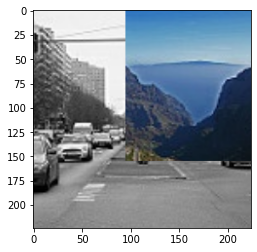

[0. 1. 0. 0. 0. 0.]


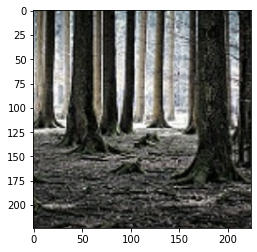

[0.6269133  0.37308672 0.         0.         0.         0.        ]


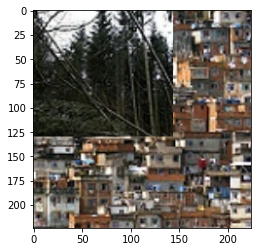

[0.         0.         0.49316406 0.         0.         0.50683594]


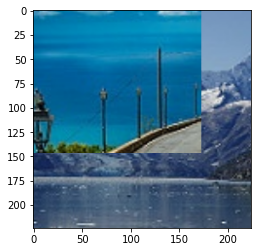

[0.         0.         0.6603954  0.         0.33960462 0.        ]


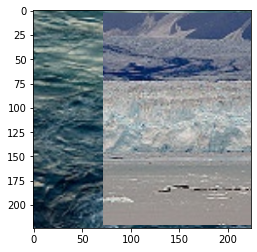

In [31]:
for images, labels in train_ds.take(5):
  plt.imshow(images[0].numpy().astype('uint8'))
  print(labels[0].numpy())
  plt.show()  

### 문제 13. cutmix 적용하여 training
    - model을 새로 생성하고 학습하여 결과를 확인해봅시다.
    - 다른 hyperparameter는 이전과 동일하게 하여 결과를 비교해봅시다.

In [32]:
model = create_model()

In [33]:
model.compile(keras.optimizers.Adam(LR), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/100
219/219 [==============================] - 44s 178ms/step - loss: 0.7010 - accuracy: 0.8741 - val_loss: 0.3282 - val_accuracy: 0.9317
Epoch 2/100
219/219 [==============================] - 39s 175ms/step - loss: 0.6373 - accuracy: 0.8978 - val_loss: 0.3292 - val_accuracy: 0.9403
Epoch 3/100
219/219 [==============================] - 39s 174ms/step - loss: 0.6115 - accuracy: 0.9034 - val_loss: 0.3469 - val_accuracy: 0.9333
Epoch 4/100
219/219 [==============================] - 39s 176ms/step - loss: 0.5890 - accuracy: 0.9052 - val_loss: 0.3414 - val_accuracy: 0.9393
Epoch 5/100
219/219 [==============================] - 39s 175ms/step - loss: 0.5713 - accuracy: 0.9102 - val_loss: 0.3345 - val_accuracy: 0.9387
Epoch 6/100
219/219 [==============================] - 39s 175ms/step - loss: 0.5626 - accuracy: 0.9102 - val_loss: 0.3382 - val_accuracy: 0.9397
Epoch 7/100
219/219 [==============================] - 39s 175ms/step - loss: 0.5424 - accuracy: 0.9154 - val_loss: 0.3289 -

### 문제 14. Bigger resolution
    - input image resolution을 320x320으로 키워봅시다.
    - random crop을 적용하기 전 resolution은 330x330으로 설정합니다.
    - resolution에 맞게 train_ds와 val_ds를 다시 생성하고, data augmentation을 동일하게 적용합니다.

  

In [34]:
## Hyper-Parameter 설정
# image resolution
RES_BEF = 330
RES = 320
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 100
# learning rate
LR = 0.0001

In [35]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    label_mode='categorical',
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [36]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

### 문제 15. Learning rate warmup + cosine decay 구현하기
    - custom learning rate scheduler를 만들어서 warm up과 cosine anealing을 구현해봅시다.
    - max_lr, warmup_steps, decay_steps 세가지 항목을 입력을 받을 수 있도록 합니다. 
    - max_lr은 최대 learning rate, warmup_steps는 warm up이 끝나는 step 수, decay steps는 cosine decay가 끝나는 step 수를 의미합니다.
    - keras.optimizers.schedules.LearningRateSchedule를 상속하여 subclass로 만듭니다.
    - 자세한 사항은 아래 링크들을 참고하시면 됩니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

https://www.tensorflow.org/tutorials/text/transformer

In [57]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, max_lr, warmup_steps, decay_steps):
    super(CustomSchedule, self).__init__()
    self.max_lr = max_lr
    self.warmup_steps = warmup_steps
    self.decay_steps = decay_steps

  def __call__(self, step):
    lr = tf.cond(step < self.warmup_steps, 
                 lambda: self.max_lr / self.warmup_steps * step, 
                 lambda: 0.5 * (1+tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps))*self.max_lr)
    return lr

### 문제 16. Learning rate scheduling visualization
    - 위에서 작성한 learning rate scheduling class가 제대로 동작하는지 적당한 값을 넣고 graph를 그려서 확인해봅시다.

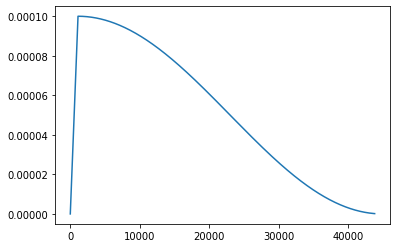

In [58]:
steps_per_epoch = N_TRAIN // N_BATCH
lr_schedule = CustomSchedule(LR, 5*steps_per_epoch, 200*steps_per_epoch)
lr = []
for step in range(steps_per_epoch*200):
  lr.append(lr_schedule(step))
step_list = list(np.arange(steps_per_epoch*200)+1)
plt.plot(step_list, lr)
plt.show()

### 문제 17. Label smoothing 적용하여 학습하기
    - 위에서 새로 적용한 모든 것들(resolution, epoch 수, learning rate scheduling)을 다 반영하고, label smoothing까지 적용하여 학습해봅시다.
    - max_lr은 LR로, warmup_steps는 3 epoch에 해당하는 step수, decay_steps는 N_EPOCH에 해당하는 step수만큼으로 설정합니다.
    - label smoothing 값은 0.1로 설정합니다.

In [59]:
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [60]:
model = create_model()

In [61]:
lr_schedule = CustomSchedule(LR, 3*steps_per_epoch, N_EPOCH*steps_per_epoch)
model.compile(keras.optimizers.Adam(lr_schedule), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/100
219/219 [==============================] - 68s 284ms/step - loss: 1.5662 - accuracy: 0.4481 - val_loss: 1.0100 - val_accuracy: 0.7237
Epoch 2/100
219/219 [==============================] - 62s 281ms/step - loss: 1.0498 - accuracy: 0.7665 - val_loss: 0.8220 - val_accuracy: 0.8190
Epoch 3/100
219/219 [==============================] - 62s 281ms/step - loss: 0.9576 - accuracy: 0.8202 - val_loss: 0.8151 - val_accuracy: 0.8253
Epoch 4/100
219/219 [==============================] - 62s 280ms/step - loss: 0.9140 - accuracy: 0.8382 - val_loss: 0.7653 - val_accuracy: 0.8540
Epoch 5/100
219/219 [==============================] - 62s 282ms/step - loss: 0.8909 - accuracy: 0.8463 - val_loss: 0.7324 - val_accuracy: 0.8770
Epoch 6/100
219/219 [==============================] - 62s 281ms/step - loss: 0.8680 - accuracy: 0.8524 - val_loss: 0.6926 - val_accuracy: 0.8957
Epoch 7/100
219/219 [==============================] - 62s 280ms/step - loss: 0.8558 - accuracy: 0.8587 - val_loss: 0.6693 -

### 문제 18. Learning rate decay(계단식) 적용하여 학습하기
    - 계단식으로 learning rate decay를 적용해봅시다.
    - 매 30 epoch마다 1/10로 learning rate을 decay 시키도록 하여 학습해봅시다.
    - 구현은 keras.optimizers.schedules.ExponentialDecay API를 활용합니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

In [63]:
model = create_model()

In [64]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(LR, steps_per_epoch*30, 0.1, True)

In [65]:
model.compile(keras.optimizers.Adam(lr_schedule), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/100
219/219 [==============================] - 67s 283ms/step - loss: 0.8416 - accuracy: 0.8819 - val_loss: 0.5857 - val_accuracy: 0.9413
Epoch 2/100
219/219 [==============================] - 62s 281ms/step - loss: 0.7802 - accuracy: 0.9065 - val_loss: 0.5925 - val_accuracy: 0.9433
Epoch 3/100
219/219 [==============================] - 62s 281ms/step - loss: 0.7670 - accuracy: 0.9088 - val_loss: 0.5968 - val_accuracy: 0.9437
Epoch 4/100
219/219 [==============================] - 62s 281ms/step - loss: 0.7623 - accuracy: 0.9099 - val_loss: 0.5953 - val_accuracy: 0.9447
Epoch 5/100
219/219 [==============================] - 62s 279ms/step - loss: 0.7463 - accuracy: 0.9200 - val_loss: 0.5817 - val_accuracy: 0.9480
Epoch 6/100
219/219 [==============================] - 62s 281ms/step - loss: 0.7418 - accuracy: 0.9155 - val_loss: 0.5850 - val_accuracy: 0.9457
Epoch 7/100
219/219 [==============================] - 62s 280ms/step - loss: 0.7375 - accuracy: 0.9152 - val_loss: 0.5784 -